In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
data = pd.read_csv('emo.csv')
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
new_data = data.drop(columns=['Unnamed: 0'])

In [6]:
new_data.isnull().any()

text     False
label    False
dtype: bool

In [7]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

new_data['label'] = new_data['label'].map(emotion_map)

In [8]:
new_data.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


([<matplotlib.patches.Wedge at 0x198804b46d0>,
 [Text(-1.027486965805527, -0.39277287979155556, 'joy'),
  Text(0.766539863322877, -0.7889338615732913, 'sadness'),
  Text(0.9402778083872817, 0.5708569374671822, 'anger'),
  Text(0.25455646491196415, 1.0701406478456579, 'fear'),
  Text(-0.414671669647339, 1.018846115167491, 'love'),
  Text(-0.7576677404311323, 0.7974582090053262, 'surprise')],
 [Text(-0.5604474358939238, -0.21423975261357572, '33.8%'),
  Text(0.4181126527215692, -0.4303275608581589, '29.1%'),
  Text(0.5128788045748809, 0.31137651134573574, '13.8%'),
  Text(0.13884898086107134, 0.583713080643086, '11.4%'),
  Text(-0.2261845470803667, 0.5557342446368132, '8.3%'),
  Text(-0.41327331296243575, 0.43497720491199604, '3.6%')])

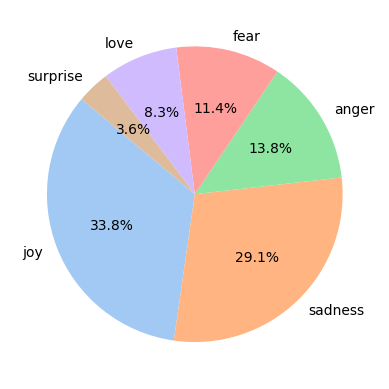

In [9]:
import matplotlib.pyplot as plt

count = new_data['label'].value_counts()
sns.set_palette('pastel')
plt.pie(count, labels = count.index, autopct='%1.1f%%', startangle=140)

In [10]:
nltk.download('wordnet')

def clean_text(text):
  text = text.lower()
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'www\.\S+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('\w*\d\w*', '', text)

  tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in tokens if token not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  cleaned_text = ' '.join(tokens)
  return cleaned_text

new_data['cleaned_text'] = new_data['text'].apply(clean_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(new_data['cleaned_text'])

In [12]:
y = new_data['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [13]:
nb_model = MultinomialNB()  # MultinomialNB is suitable for text data
nb_model.fit(X_train, y_train)
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Initialize the Multinomial Naive Bayes model with the best alpha value
nb_model_tuned = MultinomialNB(alpha=best_alpha)

# Fit the model on the training data
nb_model_tuned.fit(X_train, y_train)

MultinomialNB(alpha=0.5)

In [14]:
from sklearn.metrics import accuracy_score
y_pred = nb_model_tuned.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
score = nb_model_tuned.score(X_train,y_train)
print("Score:", score)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Score: 0.8598128038338927
Accuracy: 0.8497396895467959
Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.79      0.86     11441
        fear       0.89      0.73      0.80      9594
         joy       0.80      0.97      0.88     28164
        love       0.95      0.49      0.65      6929
     sadness       0.86      0.95      0.90     24201
    surprise       0.96      0.33      0.49      3033

    accuracy                           0.85     83362
   macro avg       0.90      0.71      0.76     83362
weighted avg       0.86      0.85      0.84     83362



In [15]:
import joblib

joblib.dump(nb_model_tuned, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']